A. Apply K-means on the image (RGB color space) and try it with three different K values (your K should be > 3) and show the results. You should use 50 random initial guesses to select the best result based on the objective function for each K.

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pairwise_dist(x, y):  
    xSumSquare = np.sum(np.square(x), axis=1)
    ySumSquare = np.sum(np.square(y), axis=1)
    mul = np.dot(x, y.T)
    dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
    return dists

def update_assignment(centers, points):
    row, col = points.shape
    cluster_idx = np.empty([row])
    distances = pairwise_dist(points, centers)
    cluster_idx = np.argmin(distances, axis=1)
    return cluster_idx

def update_centers(old_centers, cluster_idx, points):  
    K, D = old_centers.shape
    new_centers = np.empty(old_centers.shape)
    for i in range(K):
        new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
    return new_centers

def get_loss(centers, cluster_idx, points):  
    dists = pairwise_dist(points, centers)
    loss = 0.0
    N, D = points.shape
    for i in range(N):
        loss = loss + np.square(dists[i][cluster_idx[i]])
    return loss

# A. Apply K-means on the image (RGB color space)
def kmeans(image, K, max_iters = 10, abs_tol = 1e-16, rel_tol = 1e-16):
    vectorized = image.reshape((-1,3)) # Convert the M x N x 3 image into a K x 3 matrix where K = M x N and each row is now a vector in the 3-D space of RGB.
    vectorized = np.float32(vectorized) # Convert the unit8 values to float.
    row, col = vectorized.shape
    retArr = np.empty([K, col])
    c_idx = []
    cent = []
    t_loss = []
    # Use 50 random initial guesses.
    for i in range(50):
        total_loss = 0
        # Randomly initialize the cluster centers; c1, c2, ..., ck.
        for number in range(K):
            randIndex = np.random.randint(row)
            retArr[number] = vectorized[randIndex]    
        centers = retArr 
        for i in range(max_iters):   
            cluster_idx = update_assignment(centers, vectorized)
            centers = update_centers(centers, cluster_idx, vectorized)  
            loss = get_loss(centers, cluster_idx, vectorized)     
            K = centers.shape[0]
            if i > 0:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            total_loss = total_loss + loss
        c_idx.append(cluster_idx)
        cent.append(centers)
        t_loss.append(total_loss)
        # Select minimum loss position.
        idx = t_loss.index(min(t_loss))
    return c_idx[idx], cent[idx]

def assign_color_kmeans(image, cluster_idx, centers, K):
    row, column, depth = image.shape[0:3]
    image_values = image.reshape(row * column, depth) # Flatten the image_values
    updated_image_values = np.copy(image_values)
    # Assign each pixel to cluster
    for i in range(0, K):
        indices_current_cluster = np.where(cluster_idx == i)[0]
        updated_image_values[indices_current_cluster] = centers[i]
    updated_image_values = updated_image_values.reshape(row, column, depth)
    return updated_image_values

# Read 2-image image.
img1 = cv2.imread('2-image.jpg')
c_idx1, cent1 = kmeans(img1, K = 5)
c_idx2, cent2 = kmeans(img1, K = 7)
c_idx3, cent3 = kmeans(img1, K = 9)
seg_img1 = assign_color_kmeans(img1, cluster_idx = c_idx1, centers = cent1, K = 5)
seg_img2 = assign_color_kmeans(img1, cluster_idx = c_idx2, centers = cent2, K = 7)
seg_img3 = assign_color_kmeans(img1, cluster_idx = c_idx3, centers = cent3, K = 9)
cv2.imwrite('./output/image/2-image after K-means (K = 5).jpg', seg_img1)
cv2.imwrite('./output/image/2-image after K-means (K = 7).jpg', seg_img2)
cv2.imwrite('./output/image/2-image after K-means (K = 9).jpg', seg_img3) 

# Read 2-masterpiece image.
img2 = cv2.imread('2-masterpiece.jpg')
c_idx4, cent4 = kmeans(img2, K = 5)
c_idx5, cent5 = kmeans(img2, K = 7)
c_idx6, cent6 = kmeans(img2, K = 9)
seg_img4 = assign_color_kmeans(img2, cluster_idx = c_idx4, centers = cent4, K = 5)
seg_img5 = assign_color_kmeans(img2, cluster_idx = c_idx5, centers = cent5, K = 7)
seg_img6 = assign_color_kmeans(img2, cluster_idx = c_idx6, centers = cent6, K = 9)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means (K = 5).jpg', seg_img4)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means (K = 7).jpg', seg_img5)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means (K = 9).jpg', seg_img6) 


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


True

B. Implement K-means++ to have better initial guess. 

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pairwise_dist(x, y):  
    xSumSquare = np.sum(np.square(x), axis=1)
    ySumSquare = np.sum(np.square(y), axis=1)
    mul = np.dot(x, y.T)
    dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
    return dists

def update_assignment(centers, points):
    row, col = points.shape
    cluster_idx = np.empty([row])
    distances = pairwise_dist(points, centers)
    cluster_idx = np.argmin(distances, axis=1)
    return cluster_idx

def update_centers(old_centers, cluster_idx, points):  
    K, D = old_centers.shape
    new_centers = np.empty(old_centers.shape)
    for i in range(K):
        new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
    return new_centers

def get_loss(centers, cluster_idx, points):  
    dists = pairwise_dist(points, centers)
    loss = 0.0
    N, D = points.shape
    for i in range(N):
        loss = loss + np.square(dists[i][cluster_idx[i]])
    return loss

# Apply K-means on the image (RGB space).
def kmeans_pp(image, K, max_iters = 10, abs_tol = 1e-16, rel_tol = 1e-16):
    vectorized = image.reshape((-1,3)) # Convert the M x N x 3 image into a K x 3 matrix where K = M x N and each row is now a vector in the 3-D space of RGB.
    vectorized = np.float32(vectorized) # Convert the unit8 values to float.
    row, col = vectorized.shape
    retArr = np.empty([K, col])
    c_idx = []
    cent = []
    t_loss = []
    # Use 50 random initial guesses
    for i in range(50):
        total_loss = 0
        # B. Implement K-means++ to have better initial guess.
        centers = np.random.choice(row) # Randomly choose the first center.
        retArr[0] = vectorized[centers]
        dists = pairwise_dist(vectorized, np.array([retArr[0]])).flatten()
        # Repeat until k centers are selected.
        for number in range(K-1):
            prob = dists ** 2
            new_idx = np.random.choice(row, size = 1, p = prob / np.sum(prob)) # Pick the next new center from dataset with probability proportional to sum(||p-ci||^2).
            retArr[number + 1] = vectorized[new_idx]
        centers = retArr 
        for i in range(max_iters):   
            cluster_idx = update_assignment(centers, vectorized)
            centers = update_centers(centers, cluster_idx, vectorized)  
            loss = get_loss(centers, cluster_idx, vectorized)     
            K = centers.shape[0]
            if i > 0:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            total_loss = total_loss + loss
        c_idx.append(cluster_idx)
        cent.append(centers)
        t_loss.append(total_loss)
        # Select minimum loss position.
        idx = t_loss.index(min(t_loss)) 
    return c_idx[idx], cent[idx]

def assign_color_kmeans(image, cluster_idx, centers, K):
    row, column, depth = image.shape[0:3]
    image_values = image.reshape(row * column, depth) # Flatten the image_values
    updated_image_values = np.copy(image_values)
    # Assign each pixel to cluster
    for i in range(0, K):
        indices_current_cluster = np.where(cluster_idx == i)[0]
        updated_image_values[indices_current_cluster] = centers[i]
    updated_image_values = updated_image_values.reshape(row, column, depth)
    return updated_image_values
    
# Read 2-image image.
img1 = cv2.imread('2-image.jpg')
c_idx1, cent1 = kmeans_pp(img1, K = 5)
c_idx2, cent2 = kmeans_pp(img1, K = 7)
c_idx3, cent3 = kmeans_pp(img1, K = 9)
seg_img1 = assign_color_kmeans(img1, cluster_idx = c_idx1, centers = cent1, K = 5)
seg_img2 = assign_color_kmeans(img1, cluster_idx = c_idx2, centers = cent2, K = 7)
seg_img3 = assign_color_kmeans(img1, cluster_idx = c_idx3, centers = cent3, K = 9)
cv2.imwrite('./output/image/2-image after K-means with K-means++ (K = 5).jpg', seg_img1)
cv2.imwrite('./output/image/2-image after K-means with K-means++ (K = 7).jpg', seg_img2)
cv2.imwrite('./output/image/2-image after K-means with K-means++ (K = 9).jpg', seg_img3) 

# Read 2-masterpiece image.
img2 = cv2.imread('2-masterpiece.jpg')
c_idx4, cent4 = kmeans_pp(img2, K = 5)
c_idx5, cent5 = kmeans_pp(img2, K = 7)
c_idx6, cent6 = kmeans_pp(img2, K = 9)
seg_img4 = assign_color_kmeans(img2, cluster_idx = c_idx4, centers = cent4, K = 5)
seg_img5 = assign_color_kmeans(img2, cluster_idx = c_idx5, centers = cent5, K = 7)
seg_img6 = assign_color_kmeans(img2, cluster_idx = c_idx6, centers = cent6, K = 9)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means with K-means++ (K = 5).jpg', seg_img4)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means with K-means++ (K = 7).jpg', seg_img5)
cv2.imwrite('./output/masterpiece/2-masterpiece after K-means with K-means++ (K = 9).jpg', seg_img6) 

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


True

C. Implement the mean-shift algorithm to segment the same colors in the target image. Select appropriate parameters in the Uniform Kernel on the RGB color space to achieve optimal image segmentation (show the clustered result), and then show the pixel distributions in the R*G*B feature space before and after applying mean-shift (see Unit7 p.31).

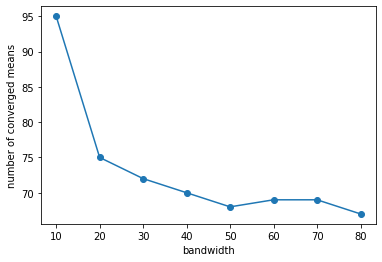

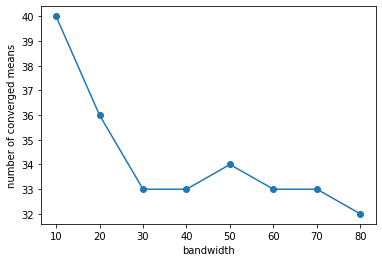

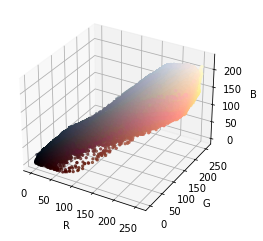

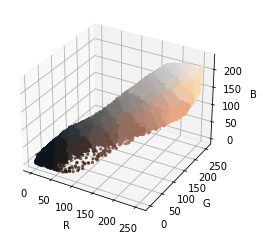

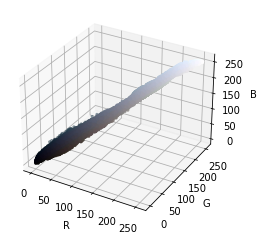

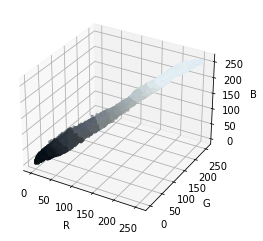

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

# C. Implement the mean-shift algorithm to segment the same colors in the target image. 
def mean_shift_color(image, bandwidth, Bin, threshold):
	row, col = image.shape[0], image.shape[1]
	means = []
	for r in range(0, row, Bin):
		for c in range(0, col, Bin):
			seed = np.array([image[r][c][0], image[r][c][1],  image[r][c][2]])
			for n in range(15):
				x = r
				y = c
				r1 = max(0, x - Bin)
				r2 = min(r1 + Bin * 2, row)
				c1 = max(0, y - Bin)
				c2 = min(c1 + Bin * 2, col)
				kernel = []
				for i in range(r1,r2):
					for j in range(c1,c2):
						dc = np.linalg.norm(image[i][j] - seed)
						if dc < bandwidth:
							kernel.append([image[i][j][0], image[i][j][1], image[i][j][2]])
				kernel = np.array(kernel)			
				mean = np.mean(kernel, axis = 0, dtype = np.int64) # C. Uniform Kernel
				dc = np.linalg.norm(seed - mean)
				seed = mean
				if dc <= threshold:
					break
			means.append(seed)

	flags = [1 for me in means]
	for i in range(len(means)):
		if flags[i] == 1:
			w = 1.0
			j = i + 1
			while j < len(means):
				dc = np.linalg.norm(means[i] - means[j])
				if dc < bandwidth:
					means[i] = means[i] + means[j]
					w = w + 1.0
					flags[j] = 0
				j = j + 1
			means[i] = means[i]/w
	converged_means = []
	for i in range(len(means)):
		if flags[i] == 1:
			converged_means.append(means[i])
	return np.array(converged_means)

def assign_color_mean_shift(image, converged_means):
	row, col = image.shape[0], image.shape[1]
	meandist = np.full((row, col), 1000.0)
	labels = np.full((row, col), -1)
	segmented_img = np.copy(image)
	for i in range(row):
		for j in range(col):
			for c in range(len(converged_means)):
				dc = np.linalg.norm(image[i][j] - converged_means[c])
				if dc < meandist[i][j]:
					meandist[i][j] = dc
					labels[i][j] = c
			segmented_img[i][j] = converged_means[labels[i][j]]
	return segmented_img, len(converged_means)

img1 = cv2.imread('2-image.jpg')
converged_means1 = mean_shift_color(img1, bandwidth = 10, Bin = 40, threshold = 1.0)
converged_means2 = mean_shift_color(img1, bandwidth = 20, Bin = 40, threshold = 1.0)
converged_means3 = mean_shift_color(img1, bandwidth = 30, Bin = 40, threshold = 1.0)
converged_means4 = mean_shift_color(img1, bandwidth = 40, Bin = 40, threshold = 1.0)
converged_means5 = mean_shift_color(img1, bandwidth = 50, Bin = 40, threshold = 1.0)
converged_means6 = mean_shift_color(img1, bandwidth = 60, Bin = 40, threshold = 1.0)
converged_means7 = mean_shift_color(img1, bandwidth = 70, Bin = 40, threshold = 1.0)
converged_means8 = mean_shift_color(img1, bandwidth = 80, Bin = 40, threshold = 1.0)
img_meanshift1, length1 = assign_color_mean_shift(img1, converged_means1)
img_meanshift2, length2 = assign_color_mean_shift(img1, converged_means2)
img_meanshift3, length3 = assign_color_mean_shift(img1, converged_means3)
img_meanshift4, length4 = assign_color_mean_shift(img1, converged_means4)
img_meanshift5, length5 = assign_color_mean_shift(img1, converged_means5)
img_meanshift6, length6 = assign_color_mean_shift(img1, converged_means6)
img_meanshift7, length7 = assign_color_mean_shift(img1, converged_means7)
img_meanshift8, length8 = assign_color_mean_shift(img1, converged_means8)

# Show 2-image bandwith vs number of converged means (color information)
x = [10, 20, 30, 40, 50, 60, 70, 80]
y = [length1, length2, length3, length4, length5, length6, length7, length8]
fig1 = plt.figure()
plt.plot(x, y, marker = 'o')
plt.xlabel('bandwidth')
plt.ylabel('number of converged means')
plt.savefig('./output/image/bandwith vs number of converged means (color information).jpg')
cv2.imwrite('./output/image/2-image after mean-shift with color information (bandwidth = 30).jpg', img_meanshift3)

img2 = cv2.imread('2-masterpiece.jpg')
converged_means9 = mean_shift_color(img2, bandwidth = 10, Bin = 40, threshold = 1.0)
converged_means10 = mean_shift_color(img2, bandwidth = 20, Bin = 40, threshold = 1.0)
converged_means11 = mean_shift_color(img2, bandwidth = 30, Bin = 40, threshold = 1.0)
converged_means12 = mean_shift_color(img2, bandwidth = 40, Bin = 40, threshold = 1.0)
converged_means13 = mean_shift_color(img2, bandwidth = 50, Bin = 40, threshold = 1.0)
converged_means14 = mean_shift_color(img2, bandwidth = 60, Bin = 40, threshold = 1.0)
converged_means15 = mean_shift_color(img2, bandwidth = 70, Bin = 40, threshold = 1.0)
converged_means16 = mean_shift_color(img2, bandwidth = 80, Bin = 40, threshold = 1.0)
img_meanshift9, length9 = assign_color_mean_shift(img2, converged_means9)
img_meanshift10, length10 = assign_color_mean_shift(img2, converged_means10)
img_meanshift11, length11 = assign_color_mean_shift(img2, converged_means11)
img_meanshift12, length12 = assign_color_mean_shift(img2, converged_means12)
img_meanshift13, length13 = assign_color_mean_shift(img2, converged_means13)
img_meanshift14, length14 = assign_color_mean_shift(img2, converged_means14)
img_meanshift15, length15 = assign_color_mean_shift(img2, converged_means15)
img_meanshift16, length16 = assign_color_mean_shift(img2, converged_means16)

# Show 2-masterpiece bandwith vs number of converged means (color information)
x = [10, 20, 30, 40, 50, 60, 70, 80]
y = [length9, length10, length11, length12, length13, length14, length15, length16]
fig2 = plt.figure()
plt.plot(x, y, marker = 'o')
plt.xlabel('bandwidth')
plt.ylabel('number of converged means')
plt.savefig('./output/masterpiece/bandwith vs number of converged means (color information).jpg')
cv2.imwrite('./output/masterpiece/2-masterpiece after mean-shift with color information (bandwidth = 30).jpg', img_meanshift11)

# C. Show the 2-image pixel distributions in the R*G*B feature space before applying mean-shift.
img1_before_meanshift = cv2.imread('2-image.jpg')
img1_before_meanshift = cv2.cvtColor(img1_before_meanshift, cv2.COLOR_BGR2RGB)
r1, g1, b1 = cv2.split(img1_before_meanshift)
fig3 = plt.figure()
axis = fig3.add_subplot(1, 1, 1, projection = '3d')
pixel_colors1 = img1_before_meanshift.reshape((np.shape(img1_before_meanshift)[0]*np.shape(img1_before_meanshift)[1], 3))
norm = colors.Normalize(vmin = -1., vmax = 1.)
norm.autoscale(pixel_colors1)
pixel_colors1 = norm(pixel_colors1).tolist()
axis.scatter(r1.flatten(), g1.flatten(), b1.flatten(), facecolors = pixel_colors1, marker = ".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B")
plt.savefig('./output/image/2-image pixel distribution before mean-shift.jpg')

# C. Show the 2-image pixel distributions in the R*G*B feature space after applying mean-shift.
img1_after_meanshift = cv2.imread('./output/image/2-image after mean-shift with color information (bandwidth = 30).jpg')
img1_after_meanshift = cv2.cvtColor(img1_after_meanshift, cv2.COLOR_BGR2RGB)
r2, g2, b2 = cv2.split(img1_before_meanshift)
fig4 = plt.figure()
axis = fig4.add_subplot(1, 1, 1, projection = '3d')
pixel_colors2 = img1_after_meanshift .reshape((np.shape(img1_after_meanshift)[0]*np.shape(img1_after_meanshift)[1], 3))
norm = colors.Normalize(vmin = -1., vmax = 1.)
norm.autoscale(pixel_colors2)
pixel_colors2 = norm(pixel_colors2).tolist()
axis.scatter(r2.flatten(), g2.flatten(), b2.flatten(), facecolors = pixel_colors2, marker = ".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B")
plt.savefig('./output/image/2-image pixel distribution after mean-shift (bandwidth = 30).jpg')

# C. Show the 2-masterpiece pixel distributions in the R*G*B feature space before applying mean-shift.
img2_before_meanshift = cv2.imread('2-masterpiece.jpg')
r3, g3, b3 = cv2.split(img2_before_meanshift)
fig5 = plt.figure()
axis = fig5.add_subplot(1, 1, 1, projection = '3d')
pixel_colors3 = img2_before_meanshift.reshape((np.shape(img2_before_meanshift)[0]*np.shape(img2_before_meanshift)[1], 3))
norm = colors.Normalize(vmin = -1., vmax = 1.)
norm.autoscale(pixel_colors3)
pixel_colors3 = norm(pixel_colors3).tolist()
axis.scatter(r3.flatten(), g3.flatten(), b3.flatten(), facecolors = pixel_colors3, marker = ".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B")
plt.savefig('./output/masterpiece/2-masterpiece pixel distribution before mean-shift.jpg')

# C. Show the 2-masterpiece pixel distributions in the R*G*B feature space after applying mean-shift.
img2_after_meanshift = cv2.imread('./output/masterpiece/2-masterpiece after mean-shift with color information (bandwidth = 30).jpg')
r4, g4, b4 = cv2.split(img2_before_meanshift)
fig6 = plt.figure()
axis = fig6.add_subplot(1, 1, 1, projection = '3d')
pixel_colors4 = img2_after_meanshift .reshape((np.shape(img2_after_meanshift)[0]*np.shape(img2_after_meanshift)[1], 3))
norm = colors.Normalize(vmin = -1., vmax = 1.)
norm.autoscale(pixel_colors4)
pixel_colors4 = norm(pixel_colors4).tolist()
axis.scatter(r4.flatten(), g4.flatten(), b4.flatten(), facecolors = pixel_colors4, marker = ".")
axis.set_xlabel("R")
axis.set_ylabel("G")
axis.set_zlabel("B")
plt.savefig('./output/masterpiece/2-masterpiece pixel distribution after mean-shift (bandwidth = 30).jpg')

D. In addition, combine the color and spatial information into the kernel for mean shift segmentation and find the optimal parameters for the best segmentation result.

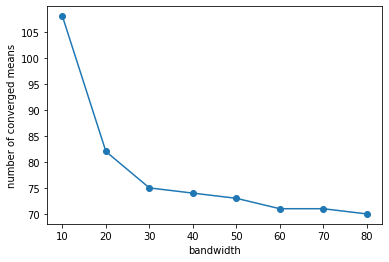

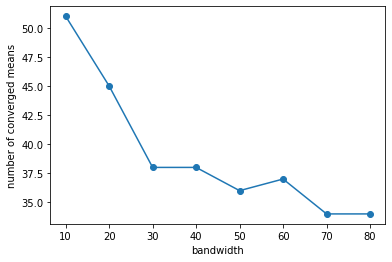

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Implement the mean-shift algorithm to segment the same colors in the target image. 
def mean_shift_color_and_spatial(image, bandwidth, Bin, m, S, threshold):
    rows, cols = image.shape[0], image.shape[1]
    means = []
    for r in range(0, rows, Bin):
        for c in range(0, cols, Bin):
            seed = np.array([r, c, image[r][c][0], image[r][c][1], image[r][c][2]])
            for n in range(15):
                x = seed[0]
                y = seed[1]
                r1 = max(0, x - Bin)
                r2 = min(r1 + Bin * 2, rows)
                c1 = max(0, y - Bin)
                c2 = min(c1 + Bin * 2, cols)
                kernel = []
                for i in range(r1,r2):
                    for j in range(c1,c2):
                        dc = np.linalg.norm(image[i][j] - seed[2:])
                        ds = (np.linalg.norm(np.array([i,j]) - seed[:2]))*m/S
                        D = np.linalg.norm([dc,ds])
                        if D < bandwidth:
                            kernel.append([i, j, image[i][j][0], image[i][j][1], image[i][j][2]]) # D. Combine the color and spatial information into the kernel for mean shift segmentation.
                kernel = np.array(kernel)			
                mean = np.mean(kernel, axis = 0, dtype = np.int64) # Uniform Kernel
                dc = np.linalg.norm(seed[2:] - mean[2:])
                ds = (np.linalg.norm(seed[:2] - mean[:2]))*m/S
                dsm = np.linalg.norm([dc,ds])
                seed = mean
                if dsm <= threshold:
                    break
            means.append(seed)

    flags = [1 for me in means]
    for i in range(len(means)):
        if flags[i] == 1:
            w = 1.0
            j = i + 1
            while j < len(means):
                dc = np.linalg.norm(means[i][2:] - means[j][2:])
                ds = (np.linalg.norm(means[i][:2] - means[j][:2]))*m/S
                dsm = np.linalg.norm([dc,ds])
                if dsm < bandwidth:
                    means[i] = means[i] + means[j]
                    w = w + 1.0
                    flags[j] = 0
                j = j + 1
            means[i] = means[i]/w
    converged_means = []
    for i in range(len(means)):
        if flags[i] == 1:
            converged_means.append(means[i])
    return np.array(converged_means)

def assign_color_mean_shift(image, converged_means, m, S):
    row, col = image.shape[0], image.shape[1]
    meandist = np.full((row, col), 1000.0)
    labels = np.full((row, col), -1)
    segmented_img = np.copy(image)
    for i in range(row):
        for j in range(col):
            for c in range(len(converged_means)):
                dc = np.linalg.norm(image[i][j] - converged_means[c][2:])
                ds = (np.linalg.norm(np.array([i,j]) - converged_means[c][:2]))*m/S
                D = np.linalg.norm([dc,ds])
                if D < meandist[i][j]:
                    meandist[i][j] = D
                    labels[i][j] = c
            segmented_img[i][j] = converged_means[labels[i][j]][2:] 
    return segmented_img, len(converged_means)

img1 = cv2.imread("2-image.jpg")
converged_means1 = mean_shift_color_and_spatial(img1, bandwidth = 10, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means2 = mean_shift_color_and_spatial(img1, bandwidth = 20, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means3 = mean_shift_color_and_spatial(img1, bandwidth = 30, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means4 = mean_shift_color_and_spatial(img1, bandwidth = 40, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means5 = mean_shift_color_and_spatial(img1, bandwidth = 50, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means6 = mean_shift_color_and_spatial(img1, bandwidth = 60, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means7 = mean_shift_color_and_spatial(img1, bandwidth = 70, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means8 = mean_shift_color_and_spatial(img1, bandwidth = 80, Bin = 40, m = 1, S = 5, threshold = 1.0)
img_meanshift1, length1 = assign_color_mean_shift(img1, converged_means1, m = 1, S = 5)
img_meanshift2, length2 = assign_color_mean_shift(img1, converged_means2, m = 1, S = 5)
img_meanshift3, length3 = assign_color_mean_shift(img1, converged_means3, m = 1, S = 5)
img_meanshift4, length4 = assign_color_mean_shift(img1, converged_means4, m = 1, S = 5)
img_meanshift5, length5 = assign_color_mean_shift(img1, converged_means5, m = 1, S = 5)
img_meanshift6, length6 = assign_color_mean_shift(img1, converged_means6, m = 1, S = 5)
img_meanshift7, length7 = assign_color_mean_shift(img1, converged_means7, m = 1, S = 5)
img_meanshift8, length8 = assign_color_mean_shift(img1, converged_means8, m = 1, S = 5)

x = [10, 20, 30, 40, 50, 60, 70, 80]
y = [length1, length2, length3, length4, length5, length6, length7, length8]
fig1 = plt.figure()
plt.plot(x, y, marker = 'o')
plt.xlabel('bandwidth')
plt.ylabel('number of converged means')
plt.savefig('./output/image/bandwith vs number of converged means (color and spatial information).jpg')

img2 = cv2.imread('2-masterpiece.jpg')
converged_means9 = mean_shift_color_and_spatial(img2, bandwidth = 10, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means10 = mean_shift_color_and_spatial(img2, bandwidth = 20, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means11 = mean_shift_color_and_spatial(img2, bandwidth = 30, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means12 = mean_shift_color_and_spatial(img2, bandwidth = 40, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means13 = mean_shift_color_and_spatial(img2, bandwidth = 50, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means14 = mean_shift_color_and_spatial(img2, bandwidth = 60, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means15 = mean_shift_color_and_spatial(img2, bandwidth = 70, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means16 = mean_shift_color_and_spatial(img2, bandwidth = 80, Bin = 40, m = 1, S = 5, threshold = 1.0)
img_meanshift9, length9 = assign_color_mean_shift(img2, converged_means9, m = 1, S = 5)
img_meanshift10, length10 = assign_color_mean_shift(img2, converged_means10, m = 1, S = 5)
img_meanshift11, length11 = assign_color_mean_shift(img2, converged_means11, m = 1, S = 5)
img_meanshift12, length12 = assign_color_mean_shift(img2, converged_means12, m = 1, S = 5)
img_meanshift13, length13 = assign_color_mean_shift(img2, converged_means13, m = 1, S = 5)
img_meanshift14, length14 = assign_color_mean_shift(img2, converged_means14, m = 1, S = 5)
img_meanshift15, length15 = assign_color_mean_shift(img2, converged_means15, m = 1, S = 5)
img_meanshift16, length16 = assign_color_mean_shift(img2, converged_means16, m = 1, S = 5)

x = [10, 20, 30, 40, 50, 60, 70, 80]
y = [length9, length10, length11, length12, length13, length14, length15, length16]
fig2 = plt.figure()
plt.plot(x, y, marker = 'o')
plt.xlabel('bandwidth')
plt.ylabel('number of converged means')
plt.savefig('./output/masterpiece/bandwith vs number of converged means (color and spatial information).jpg')

E. Show the mean-shift segmentation results with three different sets of bandwidth parameters.

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Implement the mean-shift algorithm to segment the same colors in the target image. 
def mean_shift_color_and_spatial(image, bandwidth, Bin, m, S, threshold):
    row, col = image.shape[0], image.shape[1]
    means = []
    for r in range(0, row, Bin):
        for c in range(0, col, Bin):
            seed = np.array([r, c, image[r][c][0], image[r][c][1], image[r][c][2]])
            for n in range(15):
                x = seed[0]
                y = seed[1]
                r1 = max(0, x - Bin)
                r2 = min(r1 + Bin * 2, row)
                c1 = max(0, y - Bin)
                c2 = min(c1 + Bin * 2, col)
                kernel = []
                for i in range(r1,r2):
                    for j in range(c1,c2):
                        dc = np.linalg.norm(image[i][j] - seed[2:])
                        ds = (np.linalg.norm(np.array([i,j]) - seed[:2]))*m/S
                        D = np.linalg.norm([dc, ds])
                        if D < bandwidth:
                            kernel.append([i, j, image[i][j][0], image[i][j][1], image[i][j][2]]) # Combine the color and spatial information into the kernel for mean shift segmentation.
                kernel = np.array(kernel)			
                mean = np.mean(kernel, axis = 0, dtype = np.int64) # Uniform Kernel
                dc = np.linalg.norm(seed[2:] - mean[2:])
                ds = (np.linalg.norm(seed[:2] - mean[:2])) * m / S
                dsm = np.linalg.norm([dc, ds])
                seed = mean
                if dsm <= threshold:
                    break
            means.append(seed)

    flags = [1 for me in means]
    for i in range(len(means)):
        if flags[i] == 1:
            w = 1.0
            j = i + 1
            while j < len(means):
                dc = np.linalg.norm(means[i][2:] - means[j][2:])
                ds = (np.linalg.norm(means[i][:2] - means[j][:2])) * m / S
                dsm = np.linalg.norm([dc, ds])
                if dsm < bandwidth:
                    means[i] = means[i] + means[j]
                    w = w + 1.0
                    flags[j] = 0
                j = j + 1
            means[i] = means[i] / w
    converged_means = []
    for i in range(len(means)):
        if flags[i] == 1:
            converged_means.append(means[i])
    return np.array(converged_means)

def assign_color_mean_shift(image, converged_means, m, S):
    row, col = image.shape[0], image.shape[1]
    meandist = np.full((row, col), 1000.0)
    labels = np.full((row, col), -1)
    segmented_img = np.copy(image)
    for i in range(row):
        for j in range(col):
            for c in range(len(converged_means)):
                dc = np.linalg.norm(image[i][j] - converged_means[c][2:])
                ds = (np.linalg.norm(np.array([i,j]) - converged_means[c][:2])) * m / S
                D = np.linalg.norm([dc,ds])
                if D < meandist[i][j]:
                    meandist[i][j] = D
                    labels[i][j] = c
            segmented_img[i][j] = converged_means[labels[i][j]][2:] 
    return segmented_img, len(converged_means)

# E. Show the mean-shift segmentation results with three different sets of bandwidth parameters (2-image).
img1 = cv2.imread("2-image.jpg")
converged_means1 = mean_shift_color_and_spatial(img1, bandwidth = 10, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means3 = mean_shift_color_and_spatial(img1, bandwidth = 30, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means5 = mean_shift_color_and_spatial(img1, bandwidth = 50, Bin = 40, m = 1, S = 5, threshold = 1.0)
img_meanshift1, length1 = assign_color_mean_shift(img1, converged_means1, m = 1, S = 5)
img_meanshift3, length3 = assign_color_mean_shift(img1, converged_means3, m = 1, S = 5)
img_meanshift5, length5 = assign_color_mean_shift(img1, converged_means5, m = 1, S = 5)
cv2.imwrite('./output/image/2-image after mean-shift with color and spatial information (bandwidth = 10).jpg', img_meanshift1)
cv2.imwrite('./output/image/2-image after mean-shift with color and spatial information (bandwidth = 30).jpg', img_meanshift3)
cv2.imwrite('./output/image/2-image after mean-shift with color and spatial information (bandwidth = 50).jpg', img_meanshift5)

# E. Show the mean-shift segmentation results with three different sets of bandwidth parameters (2-masterpiece).
img2 = cv2.imread('2-masterpiece.jpg')
converged_means9 = mean_shift_color_and_spatial(img2, bandwidth = 10, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means11 = mean_shift_color_and_spatial(img2, bandwidth = 30, Bin = 40, m = 1, S = 5, threshold = 1.0)
converged_means13 = mean_shift_color_and_spatial(img2, bandwidth = 50, Bin = 40, m = 1, S = 5, threshold = 1.0)
img_meanshift9, length9 = assign_color_mean_shift(img2, converged_means9, m = 1, S = 5)
img_meanshift11, length11 = assign_color_mean_shift(img2, converged_means11, m = 1, S = 5)
img_meanshift13, length13 = assign_color_mean_shift(img2, converged_means13, m = 1, S = 5)
cv2.imwrite('./output/masterpiece/2-masterpiece after mean-shift with color and spatial information (bandwidth = 10).jpg', img_meanshift9)
cv2.imwrite('./output/masterpiece/2-masterpiece after mean-shift with color and spatial information (bandwidth = 30).jpg', img_meanshift11)
cv2.imwrite('./output/masterpiece/2-masterpiece after mean-shift with color and spatial information (bandwidth = 50).jpg', img_meanshift13)

True

F. Compare the segmentation results by using K-means and mean-shift algorithms and their computation cost.

In [26]:
import cv2
import numpy as np
import time as t

def pairwise_dist(x, y):  
    xSumSquare = np.sum(np.square(x), axis=1)
    ySumSquare = np.sum(np.square(y), axis=1)
    mul = np.dot(x, y.T)
    dists = np.sqrt(abs(xSumSquare[:, np.newaxis] + ySumSquare-2*mul))
    return dists

def update_assignment(centers, points):
    row, col = points.shape
    cluster_idx = np.empty([row])
    distances = pairwise_dist(points, centers)
    cluster_idx = np.argmin(distances, axis=1)
    return cluster_idx

def update_centers(old_centers, cluster_idx, points):  
    K, D = old_centers.shape
    new_centers = np.empty(old_centers.shape)
    for i in range(K):
        new_centers[i] = np.mean(points[cluster_idx == i], axis = 0)
    return new_centers

def get_loss(centers, cluster_idx, points):  
    dists = pairwise_dist(points, centers)
    loss = 0.0
    N, D = points.shape
    for i in range(N):
        loss = loss + np.square(dists[i][cluster_idx[i]])
    return loss

# Apply K-means on the image (RGB color space)
def kmeans(image, K, max_iters = 10, abs_tol = 1e-16, rel_tol = 1e-16):
    vectorized = image.reshape((-1,3)) # Convert the M x N x 3 image into a K x 3 matrix where K = M x N and each row is now a vector in the 3-D space of RGB.
    vectorized = np.float32(vectorized) # Convert the unit8 values to float
    row, col = vectorized.shape
    retArr = np.empty([K, col])
    c_idx = []
    cent = []
    t_loss = []
    # Use 50 random initial guesses
    for i in range(50):
        total_loss = 0
        # Randomly initialize the cluster centers; c1, c2, ..., ck.
        for number in range(K):
            randIndex = np.random.randint(row)
            retArr[number] = vectorized[randIndex]    
        centers = retArr 
        for i in range(max_iters):   
            cluster_idx = update_assignment(centers, vectorized)
            centers = update_centers(centers, cluster_idx, vectorized)  
            loss = get_loss(centers, cluster_idx, vectorized)     
            K = centers.shape[0]
            if i > 0:
                diff = np.abs(prev_loss - loss)
                if diff < abs_tol and diff / prev_loss < rel_tol:
                    break
            prev_loss = loss
            total_loss = total_loss + loss
        c_idx.append(cluster_idx)
        cent.append(centers)
        t_loss.append(total_loss)
        # Select minimum loss position.
        idx = t_loss.index(min(t_loss))
    return c_idx[idx], cent[idx]
    
# Implement the mean-shift algorithm to segment the same colors in the target image. 
def mean_shift_color_and_spatial(image, bandwidth, Bin, m, S, threshold):
    row, col = image.shape[0], image.shape[1]
    means = []
    for r in range(0, row, Bin):
        for c in range(0, col, Bin):
            seed = np.array([r, c, image[r][c][0], image[r][c][1], image[r][c][2]]) 
            for n in range(15):
                x = seed[0]
                y = seed[1]
                r1 = max(0, x - Bin)
                r2 = min(r1 + Bin * 2, row)
                c1 = max(0, y - Bin)
                c2 = min(c1 + Bin * 2, col)
                kernel = []
                for i in range(r1,r2):
                    for j in range(c1,c2):
                        dc = np.linalg.norm(image[i][j] - seed[2:])
                        ds = (np.linalg.norm(np.array([i,j]) - seed[:2]))*m/S
                        D = np.linalg.norm([dc, ds])
                        if D < bandwidth:
                            kernel.append([i, j, image[i][j][0], image[i][j][1], image[i][j][2]]) # Combine the color and spatial information into the kernel for mean shift segmentation.
                kernel = np.array(kernel)			
                mean = np.mean(kernel, axis = 0, dtype = np.int64) # Uniform Kernel
                dc = np.linalg.norm(seed[2:] - mean[2:])
                ds = (np.linalg.norm(seed[:2] - mean[:2])) * m / S
                dsm = np.linalg.norm([dc, ds])
                seed = mean
                if dsm <= threshold:
                    break
            means.append(seed)

    flags = [1 for me in means]
    for i in range(len(means)):
        if flags[i] == 1:
            w = 1.0
            j = i + 1
            while j < len(means):
                dc = np.linalg.norm(means[i][2:] - means[j][2:])
                ds = (np.linalg.norm(means[i][:2] - means[j][:2])) * m / S
                dsm = np.linalg.norm([dc,ds])
                if dsm < bandwidth:
                    means[i] = means[i] + means[j]
                    w = w + 1.0
                    flags[j] = 0
                j = j + 1
            means[i] = means[i] / w
    converged_means = []
    for i in range(len(means)):
        if flags[i] == 1:
            converged_means.append(means[i])
    return np.array(converged_means)

# Show time spend in large data set for both in K-mean and mean-shift.
img1 = cv2.imread('2-image.jpg')
start_k_means1 = t.time()
c_idx1, cent1 = kmeans(img1, K = 10)
end_k_means1 = t.time()
print(f'time spend in kmeans: {end_k_means1 - start_k_means1} s')
start_mean_shift1 = t.time()
converged_means1 = mean_shift_color_and_spatial(img1, bandwidth = 70, Bin = 5, m = 1, S = 5, threshold = 1.0)
end_mean_shift1 = t.time()
print(f'time spend in mean-shift: {end_mean_shift1 - start_mean_shift1} s')

# Show time spend in small data set for both in K-mean and mean-shift.
img1 = cv2.imread('2-image.jpg')
start_k_means2 = t.time()
c_idx1, cent1 = kmeans(img1, K = 10)
end_k_means2 = t.time()
print(f'time spend in kmeans: {end_k_means2 - start_k_means2} s')
start_mean_shift2 = t.time()
converged_means1 = mean_shift_color_and_spatial(img1, bandwidth = 50, Bin = 40, m = 1, S = 5, threshold = 1.0)
end_mean_shift2 = t.time()
print(f'time spend in mean-shift: {end_mean_shift2 - start_mean_shift2} s')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


time spend in kmeans: 325.4007086753845 s
time spend in mean-shift: 640.4421401023865 s
time spend in kmeans: 297.10562205314636 s
time spend in mean-shift: 177.78146886825562 s
